<a href="https://colab.research.google.com/github/JulienGremillot/du_coup/blob/main/du_coup_tfjs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa tensorflowjs tensorflow-io

     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 23.4 MB 1.4 MB/s 
     |████████████████████████████████| 462 kB 48.7 MB/s 


In [2]:
import glob
import json
import os
import pathlib
import random

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import tensorflow as tf
import tensorflowjs as tfjs
import tensorflow_io as tfio
import tqdm

print(tf.__version__)
print(tfjs.__version__)
print(tfio.__version__)

2.8.0
3.14.0
0.24.0


In [3]:
# Download the TensorFlow.js Speech Commands model and the associated
# preprocesssing model.
!mkdir -p /tmp/tfjs-sc-model
!curl -o /tmp/tfjs-sc-model/metadata.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/metadata.json
!curl -o /tmp/tfjs-sc-model/model.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/model.json
!curl -o /tmp/tfjs-sc-model/group1-shard1of2 -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard1of2
!curl -o /tmp/tfjs-sc-model/group1-shard2of2 -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard2of2
!curl -o /tmp/tfjs-sc-model/sc_preproc_model.tar.gz -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/conversion/sc_preproc_model.tar.gz
!cd /tmp/tfjs-sc-model/ && tar xzvf sc_preproc_model.tar.gz

sc_preproc_model/
sc_preproc_model/assets/
sc_preproc_model/variables/
sc_preproc_model/variables/variables.data-00000-of-00001
sc_preproc_model/variables/variables.index
sc_preproc_model/saved_model.pb


In [3]:
SAMPLING_RATE = 16000

from google.colab import drive
import os
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [4]:
from scipy.io import wavfile
src_du_coup = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/du_coup')
files_du_coup = os.listdir(src_du_coup)
print("On a", len(files_du_coup), "samples de 'du coup'")
lengths = {}
for file in files_du_coup:
  sample_rate, data = wavfile.read(os.path.join(src_du_coup, file))
  length = len(data) / sample_rate
  lengths[file] = length
min_length = round(min(lengths.values()), 2)
max_length = round(max(lengths.values()), 2)
print("Durée moyenne :", round(sum(lengths.values()) / len(lengths), 2), "sec.",
      "(min :", min_length, "- max :", max_length, ")")
if max_length > 1:
  print("Samples de +1 sec :")
  for file in files_du_coup:
    if lengths[file] > 1:
      print("-", file)

On a 186 samples de 'du coup'
Durée moyenne : 0.52 sec. (min : 0.23 - max : 0.89 )


In [5]:
import shutil
data_dir = '/tmp/data'
dirs = ['du_coup', 'autres', 'background']
for dir in dirs:
  src = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/' + dir)
  dst = pathlib.Path(os.path.join(data_dir, dir))
  if not dst.exists():
    print('Copie le répertoire', src, 'vers', dst)
    shutil.copytree(src, dst)
  else:
    print('Le répertoire', dst, 'existe déjà.')

Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/du_coup vers /tmp/data/du_coup
Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/autres vers /tmp/data/autres
Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/background vers /tmp/data/background


In [6]:
def print_files_info(dirs):
  print('Nombre de fichiers par répertoire :')
  for dir in dirs:
    nb_files = len(os.listdir(os.path.join(data_dir, dir)))
    print('-', dir, ':', nb_files)

  filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
  filenames = tf.random.shuffle(filenames)
  num_samples = len(filenames)
  print('\nNombre total de fichiers :', num_samples)

print_files_info(dirs)

Nombre de fichiers par répertoire :
- du_coup : 186
- autres : 75
- background : 6

Nombre total de fichiers : 267


In [12]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  res = tf.squeeze(audio, axis=-1)
  return res


def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]


def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [9]:
# Load the preprocessing model, which transforms audio waveform into 
# spectrograms (2D image-like representation of sound).
# This preprocessing model replicates WebAudio's AnalyzerNode.getFloatFrequencyData
# (https://developer.mozilla.org/en-US/docs/Web/API/AnalyserNode/getFloatFrequencyData).
# It performs short-time Fourier transform (STFT) using a length-2048 Blackman
# window. It opeartes on mono audio at the 44100-Hz sample rate.

preproc_model_path = '/tmp/tfjs-sc-model/sc_preproc_model'
preproc_model = tf.keras.models.load_model(preproc_model_path)
preproc_model.summary()
preproc_model.input_shape

Model: "audio_preproc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 audio_preprocessing_layer (  (None, None, 232, 1)     2048      
 AudioPreprocessingLayer)                                        
                                                                 
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


(None, 44032)

In [10]:
# Create some constants to be used later.

# Target sampling rate. It is required by the audio preprocessing model.
TARGET_SAMPLE_RATE = SAMPLING_RATE
# The specific audio tensor length expected by the preprocessing model.
EXPECTED_WAVEFORM_LEN = preproc_model.input_shape[-1]


WORDS = ("_background_noise_snippets_", "du_coup")

In [11]:
EXPECTED_WAVEFORM_LEN

44032

In [7]:
# On découpe les sons des répertoires "background" & "autres" en snippets de 1s.

noise_wav_paths = glob.glob(os.path.join(data_dir, "background", "*.wav"))
noise_wav_paths_2 = glob.glob(os.path.join(data_dir, "autres", "*.wav"))
snippets_dir = os.path.join(data_dir, "_background_noise_snippets_")
os.makedirs(snippets_dir, exist_ok=True)

def extract_snippets(wav_path, snippet_duration_sec=1.0):
  basename = os.path.basename(os.path.splitext(wav_path)[0])
  sample_rate, xs = wavfile.read(wav_path)
  assert xs.dtype == np.int16
  n_samples_per_snippet = int(snippet_duration_sec * sample_rate)
  i = 0
  while i + n_samples_per_snippet < len(xs):
    snippet_wav_path = os.path.join(snippets_dir, "%s_%.5d.wav" % (basename, i))
    snippet = xs[i : i + n_samples_per_snippet].astype(np.int16)
    wavfile.write(snippet_wav_path, sample_rate, snippet)
    i += n_samples_per_snippet

for noise_wav_path in noise_wav_paths:
  print("Extracting snippets from %s..." % noise_wav_path)
  extract_snippets(noise_wav_path, snippet_duration_sec=1.0)
for noise_wav_path in noise_wav_paths_2:
  print("Extracting snippets from %s..." % noise_wav_path)
  extract_snippets(noise_wav_path, snippet_duration_sec=1.0)

Extracting snippets from /tmp/data/background/running_tap.wav...
Extracting snippets from /tmp/data/background/pink_noise.wav...
Extracting snippets from /tmp/data/background/white_noise.wav...
Extracting snippets from /tmp/data/background/exercise_bike.wav...
Extracting snippets from /tmp/data/background/doing_the_dishes.wav...
Extracting snippets from /tmp/data/background/dude_miaowing.wav...
Extracting snippets from /tmp/data/autres/fr-sb-490.wav...
Extracting snippets from /tmp/data/autres/fr-sb-456.wav...
Extracting snippets from /tmp/data/autres/fr-sb-677.wav...
Extracting snippets from /tmp/data/autres/fr-sb-496.wav...
Extracting snippets from /tmp/data/autres/fr-sb-847.wav...
Extracting snippets from /tmp/data/autres/fr-sb-454.wav...
Extracting snippets from /tmp/data/autres/fr-sb-442.wav...
Extracting snippets from /tmp/data/autres/fr-sb-114.wav...
Extracting snippets from /tmp/data/autres/fr-sb-685.wav...
Extracting snippets from /tmp/data/autres/fr-sb-849.wav...
Extracting s

In [13]:
def resample_wavs(dir_path, target_sample_rate=44100):
  """Resample the .wav files in an input directory to given sampling rate.
  
  The resampled waveforms are written to .wav files in the same directory with
  file names that ends in "_44100hz.wav".

  44100 Hz is the sample rate required by the preprocessing model. It is also
  the most widely supported sample rate among web browsers and mobile devices.
  For example, see:
  https://developer.mozilla.org/en-US/docs/Web/API/AudioContextOptions/sampleRate
  https://developer.android.com/ndk/guides/audio/sampling-audio

  Args:
    dir_path: Path to a directory that contains .wav files.
    target_sapmle_rate: Target sampling rate in Hz.
  """
  wav_paths = glob.glob(os.path.join(dir_path, "*.wav"))
  resampled_suffix = "_%shz.wav" % target_sample_rate
  for i, wav_path in tqdm.tqdm(enumerate(wav_paths)):
    if wav_path.endswith(resampled_suffix):
      continue
    sample_rate, xs = wavfile.read(wav_path)
    xs = xs.astype(np.float32)
    xs = librosa.resample(xs, sample_rate, TARGET_SAMPLE_RATE).astype(np.int16)
    resampled_path = os.path.splitext(wav_path)[0] + resampled_suffix
    wavfile.write(resampled_path, target_sample_rate, xs)

du_coup_dir = os.path.join(data_dir, "du_coup")
resample_wavs(snippets_dir, target_sample_rate=TARGET_SAMPLE_RATE)
resample_wavs(du_coup_dir, target_sample_rate=TARGET_SAMPLE_RATE)

817it [00:51, 15.97it/s]
186it [00:09, 19.28it/s]


In [45]:
@tf.function
def read_wav(filepath):
  file_contents = tf.io.read_file(filepath)
  return tf.expand_dims(tf.squeeze(tf.audio.decode_wav(
      file_contents, 
      desired_channels=-1,
      desired_samples=TARGET_SAMPLE_RATE).audio, axis=-1), 0)


@tf.function
def filter_by_waveform_length(waveform, label):
  return tf.size(waveform) > EXPECTED_WAVEFORM_LEN


@tf.function
def crop_and_convert_to_spectrogram(waveform, label):
  cropped = tf.slice(waveform, begin=[0, 0], size=[1, EXPECTED_WAVEFORM_LEN])
  return tf.squeeze(preproc_model(cropped), axis=0), label


@tf.function
def spectrogram_elements_finite(spectrogram, label):
  return tf.math.reduce_all(tf.math.is_finite(spectrogram))

def get_spectrogram(waveform, label):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  #input_len = 16000
  #waveform = waveform[:input_len]
  #zero_padding = tf.zeros(
  #    [16000] - tf.shape(waveform),
  #    dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  #equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram, label

def get_spectrogram_2(tensor, label):
  spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
  return spectrogram, label

def read_wav_2(filepath):
  audio = tfio.audio.AudioIOTensor(filepath)
  audio_slice = tf.data.Dataset.from_tensor_slices(audio)
  # audio_slice = audio.to_tensor()
  audio_tensor = tf.squeeze(audio_slice, axis=[-1])
  tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
  return tensor

def get_dataset_2(input_wav_paths, labels):
  ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
  ds = ds.map(read_wav_2)
  ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
  # Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
  ds = ds.filter(filter_by_waveform_length)
  # Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
  # spectrograms using the preprocessing layer.
  ds = ds.map(get_spectrogram_2)
  #ds = ds.map(crop_and_convert_to_spectrogram)
  # Discard examples that contain infinite or NaN elements.
  #ds = ds.filter(spectrogram_elements_finite)
  return ds
  

def get_dataset(input_wav_paths, labels):
  """Get a tf.data.Dataset given input .wav files and their labels.

  The returned dataset emits 2-tuples of `(spectrogram, label)`, wherein
  - `spectrogram` is a tensor of dtype tf.float32 and shape [43, 232, 1].
    It is z-normalized (i.e., have a mean of ~0.0 and variance of ~1.0).
  - `label` is a tensor of dtype tf.int32 and shape [] (scalar).
  
  Args:
    input_wav_paths: Input audio .wav file paths as a list of string.
    labels: integer labels (class indices) of the input .wav files. Must have
      the same lengh as `input_wav_paths`.

  Returns:
    A tf.data.Dataset object as described above.
  """
  ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
  # Read audio waveform from the .wav files.
  ds = ds.map(read_wav)
  ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
  # Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
  ds = ds.filter(filter_by_waveform_length)
  # Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
  # spectrograms using the preprocessing layer.
  ds = ds.map(get_spectrogram)
  #ds = ds.map(crop_and_convert_to_spectrogram)
  # Discard examples that contain infinite or NaN elements.
  #ds = ds.filter(spectrogram_elements_finite)
  return ds

In [8]:
PITCH_FACTOR = 3
NOISE_FACTOR = 0.005
SILENCE_NOISE_FACTOR = 0.001

def get_noise(noise_length):
  z = tf.zeros(noise_length)
  noise = np.random.randn(len(z.numpy()))
  return z + noise * SILENCE_NOISE_FACTOR

def get_center_sample(waveform, verbose=False):
  length = len(waveform.numpy())
  duree = round(length / SAMPLING_RATE, 2)
  if verbose:
    print("Longueur du sample :", len(waveform.numpy()), "/", duree, "sec.")
  z_before = get_noise(round((SAMPLING_RATE - length) / 2))
  z_after = get_noise(SAMPLING_RATE - length - len(z_before))
  waveform_center = tf.concat([z_before, waveform, z_after], 0)
  duree = round(len(waveform_center.numpy()) / SAMPLING_RATE, 2)
  if verbose:
    print("Nouvelle longueur du sample :", len(waveform_center.numpy()),
          "/", duree, "sec.")
  return waveform_center


def get_left_sample(waveform, verbose=False):
  length = len(waveform.numpy())
  duree = round(length / SAMPLING_RATE, 2)
  if verbose:
    print("Longueur du sample :", len(waveform.numpy()), "/", duree, "sec.")
  z_after = get_noise(SAMPLING_RATE - length)
  waveform_left = tf.concat([waveform, z_after], 0)
  duree = round(len(waveform_left.numpy()) / SAMPLING_RATE, 2)
  if verbose:
    print("Nouvelle longueur du sample :", len(waveform_left.numpy()),
          "/", duree, "sec.")
  return waveform_left


def get_right_sample(waveform, verbose=False):
  length = len(waveform.numpy())
  duree = round(length / SAMPLING_RATE, 2)
  if verbose:
    print("Longueur du sample :", len(waveform.numpy()), "/", duree, "sec.")
  z_before = get_noise(SAMPLING_RATE - length)
  waveform_right = tf.concat([z_before, waveform], 0)
  duree = round(len(waveform_right.numpy()) / SAMPLING_RATE, 2)
  if verbose:
    print("Nouvelle longueur du sample :", len(waveform_right.numpy()),
          "/", duree, "sec.")
  return waveform_right


def get_noisy_sample(waveform):
  length = len(waveform.numpy())
  z_before = get_noise(round((SAMPLING_RATE - length) / 2))
  noise = np.random.randn(len(waveform.numpy()))
  noisy_waveform = waveform + noise * NOISE_FACTOR
  z_after = get_noise(SAMPLING_RATE - length - len(z_before))
  return tf.concat([z_before, noisy_waveform, z_after], 0)


def get_pitch_sample(waveform):
    value = librosa.effects.pitch_shift(waveform.numpy(), SAMPLING_RATE, PITCH_FACTOR)
    return tf.convert_to_tensor(value)


def get_stretched_sample(waveform):
    speed_factor = len(waveform.numpy()) / SAMPLING_RATE
    value = librosa.effects.time_stretch(waveform.numpy(), speed_factor)
    return tf.convert_to_tensor(value)

In [13]:
def data_augmentation(wav_path):
  """Réalise une augmentation de données pour les fichiers .wav du répertoire.
  
  Les fichiers d'entrée peuvent avoir une durée variable, inférieure à 1 sec.
  Les fichiers de sortie feront tous 1 sec. et auront les variations :
  - son au début du sample
  - son au milieu du sample
  - son à la fin du sample
  - son avec du bruit aléatoire
  - son avec un pitch augmenté
  - son étiré jusqu'à la durée de 1 sec.

  Soit un total de 6 fichiers de sortie par fichier d'entrée.

  Args:
    wav_path: Chemin d'un répertoire contenant des fichiers .wav
  """
  #wav_paths = glob.glob(os.path.join(wav_path, "*_%shz.wav" % TARGET_SAMPLE_RATE))
  wav_paths = glob.glob(os.path.join(wav_path, "*.wav"))
  for i, wav_path in tqdm.tqdm(enumerate(wav_paths)):
    if '_left.wav' not in wav_path and \
       '_center.wav' not in wav_path and \
       '_right.wav' not in wav_path and \
       '_noisy.wav' not in wav_path and \
       '_pitch.wav' not in wav_path and \
       '_stretched.wav' not in wav_path:
      #try:
      audio_binary = tf.io.read_file(wav_path)
      waveform = decode_audio(audio_binary)
      waveform_left = get_left_sample(waveform)
      waveform_center = get_center_sample(waveform)
      waveform_right = get_right_sample(waveform)
      waveform_noisy = get_noisy_sample(waveform)
      waveform_pitch = get_pitch_sample(waveform_center)
      waveform_stretched = get_stretched_sample(waveform)
      left_filename = os.path.splitext(wav_path)[0] + '_left.wav'
      center_filename = os.path.splitext(wav_path)[0] + '_center.wav'
      right_filename = os.path.splitext(wav_path)[0] + '_right.wav'
      noisy_filename = os.path.splitext(wav_path)[0] + '_noisy.wav'
      pitch_filename = os.path.splitext(wav_path)[0] + '_pitch.wav'
      stretched_filename = os.path.splitext(wav_path)[0] + '_stretched.wav'
      wavfile.write(left_filename, SAMPLING_RATE,
                    (waveform_left.numpy().astype(np.int16)))
      wavfile.write(center_filename, SAMPLING_RATE,
                    (waveform_center.numpy().astype(np.int16)))
      wavfile.write(right_filename, SAMPLING_RATE, 
                    (waveform_right.numpy().astype(np.int16)))
      wavfile.write(noisy_filename, SAMPLING_RATE, 
                    (waveform_noisy.numpy().astype(np.int16)))
      wavfile.write(pitch_filename, SAMPLING_RATE,
                    (waveform_pitch.numpy().astype(np.int16)))
      wavfile.write(stretched_filename, SAMPLING_RATE, 
                    (waveform_stretched.numpy().astype(np.int16)))
      os.remove(wav_path)
      #except Exception:
      #  print("Erreur d'entrée avec le fichier", wav_path)

data_augmentation(os.path.join(data_dir, "du_coup"))
print_files_info(['du_coup', '_background_noise_snippets_'])

186it [00:11, 16.62it/s]

Nombre de fichiers par répertoire :
- du_coup : 1116
- _background_noise_snippets_ : 817

Nombre total de fichiers : 2014


In [41]:
ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
# Read audio waveform from the .wav files.
ds = ds.map(read_wav)
print("Taille 1 :", len(ds))
ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
# Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
ds = ds.filter(filter_by_waveform_length)
print("Taille 2 :", len(list(ds)))
# Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
# spectrograms using the preprocessing layer.
#ds = ds.map(get_spectrogram)
ds = ds.map(crop_and_convert_to_spectrogram)
print("Taille 3 :", len(list(ds)))
# Discard examples that contain infinite or NaN elements.
ds = ds.filter(spectrogram_elements_finite)
print("Taille 4 :", len(list(ds)))

Taille 1 : 2750
Taille 2 : 2750
Taille 3 : 2750
Taille 4 : 813


In [46]:
ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
ds.apply(read_wav_2)
#read_wav_2(list(ds)[0])
#ds = ds.map(read_wav_2)
#ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
#ds = ds.filter(filter_by_waveform_length)
#ds = ds.map(get_spectrogram_2)

ValueError: ignored

In [35]:
input_wav_paths_and_labels = []
for i, word in enumerate(WORDS):
  wav_paths = glob.glob(os.path.join(data_dir, word, "*_%shz.wav" % TARGET_SAMPLE_RATE))
  #wav_paths = glob.glob(os.path.join(data_dir, word, "*.wav"))
  print("Found %d examples for class %s" % (len(wav_paths), word))
  labels = [i] * len(wav_paths)
  input_wav_paths_and_labels.extend(zip(wav_paths, labels))

random.shuffle(input_wav_paths_and_labels)
  
input_wav_paths, labels = ([t[0] for t in input_wav_paths_and_labels],
                           [t[1] for t in input_wav_paths_and_labels])

#dataset = get_dataset(input_wav_paths, labels)
dataset = get_dataset_2(input_wav_paths, labels)

# Show some example spectrograms for inspection.
fig = plt.figure(figsize=(40, 100))
dataset_iter = iter(dataset)
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  #try:
  spectrogram, label = next(dataset_iter)
  spectrogram = spectrogram.numpy()
  label = label.numpy()
  plt.imshow(np.flipud(np.squeeze(spectrogram, -1).T), aspect=0.2)
  ax.set_title(WORDS[label])
  ax.set_xlabel("Time frame #")
  if i == 0:
    ax.set_ylabel("Frequency bin #")
  #except Exception:
  #  print("Erreur d'entrée avec le fichier", i)


Found 817 examples for class _background_noise_snippets_
Found 186 examples for class du_coup
['/tmp/data/_background_noise_snippets_/pink_noise_320000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-495_80000_44100hz.wav', '/tmp/data/_background_noise_snippets_/running_tap_640000_44100hz.wav', '/tmp/data/du_coup/du_coup_mathilde_01_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-447_64000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-455_64000_44100hz.wav', '/tmp/data/_background_noise_snippets_/exercise_bike_592000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-491_48000_44100hz.wav', '/tmp/data/_background_noise_snippets_/exercise_bike_928000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-346_80000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-683_16000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-107_32000_44100hz.wav', '/tmp/data/_background_noise_snippets_/fr-sb-847_64000_44100hz.wav', '/tmp/dat

AssertionError: ignored

/tmp/data/_background_noise_snippets_/fr-sb-491_48000_44100hz.wav
tf.Tensor([411. 474. 460. ... 434. 308. 145.], shape=(44100,), dtype=float32)
tf.Tensor([0.01254272 0.01446533 0.01403809 ... 0.01324463 0.00939941 0.00442505], shape=(44100,), dtype=float32)
/tmp/data/_background_noise_snippets_/fr-sb-145_00000_44100hz.wav
tf.Tensor([  -18.   -25.   -30. ... -3162. -1226.   287.], shape=(44100,), dtype=float32)
tf.Tensor(
[-0.00054932 -0.00076294 -0.00091553 ... -0.09649658 -0.03741455
  0.00875854], shape=(44100,), dtype=float32)
/tmp/data/_background_noise_snippets_/fr-sb-351_64000_44100hz.wav
tf.Tensor([3308. 3854. 3819. ... 1073.  774.  373.], shape=(44100,), dtype=float32)
tf.Tensor([0.10095215 0.11761475 0.11654663 ... 0.03274536 0.02362061 0.01138306], shape=(44100,), dtype=float32)
/tmp/data/_background_noise_snippets_/fr-sb-401_00000_44100hz.wav
tf.Tensor([-211. -343. -463. ...   88.   60.   28.], shape=(44100,), dtype=float32)
tf.Tensor(
[-0.00643921 -0.01046753 -0.01412964 ..

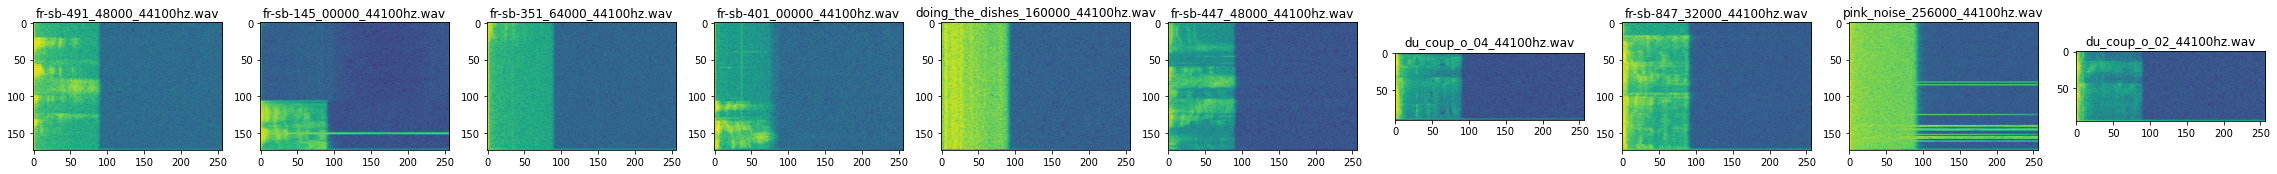

In [28]:
fig = plt.figure(figsize=(40, 100))
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  f = input_wav_paths[i]
  print(f)
  audio = tfio.audio.AudioIOTensor(f)
  audio_slice = audio.to_tensor()
  audio_tensor = tf.squeeze(audio_slice, axis=[-1])
  tensor = tf.cast(audio_tensor, tf.float32) #/ 32768.0
  print(tensor)
  tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
  print(tensor)
  spectrogram = tfio.audio.spectrogram(
    tensor, nfft=512, window=512, stride=256)
  plt.imshow(tf.math.log(spectrogram).numpy())
  ax.set_title(f.split('/')[-1])
  #plt.plot(tensor.numpy())

/tmp/data/_background_noise_snippets_/exercise_bike_704000_44100hz.wav
tf.Tensor([44100     1], shape=(2,), dtype=int64)
avant: (44100, 1)


NameError: ignored

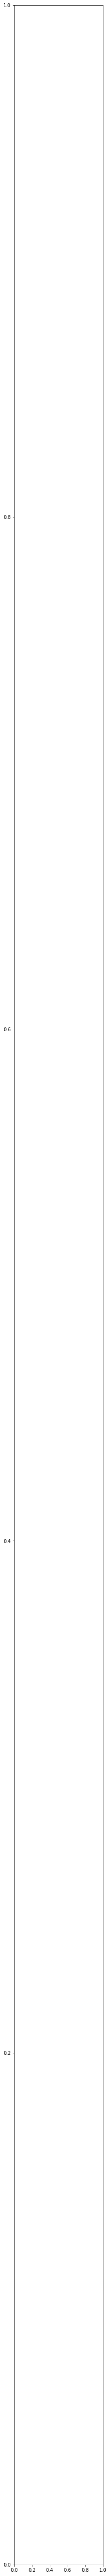

In [17]:
fig = plt.figure(figsize=(40, 100))
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  f = input_wav_paths[i]
  print(f)
  wav = read_wav(f)

  audio = tfio.audio.AudioIOTensor(f)
  print(audio.shape)
  audio_slice = audio.to_tensor()
  print('avant:', audio_slice.shape)
  audio_tensor = tf.squeeze(audio_slice, axis=[-1])
  tensor = tf.cast(audio_tensor, tf.float32) # / 32768.0
  from IPython.display import Audio
  waveform = get_noisy_sample(tensor)
  print('tensor.shape:', tensor.shape)
  print('waveform.shape:', waveform.shape)

  #audio_binary = tf.io.read_file(f)
  #waveform = decode_audio(audio_binary)
  #waveform = get_center_sample(waveform)
  waveform = tf.reshape(waveform, (1, len(waveform)))
  print('waveform.reshape:', waveform.shape)
  #waveform = tf.squeeze(waveform, axis=0)

  cropped = tf.slice(waveform, begin=[0, 0], size=[1, EXPECTED_WAVEFORM_LEN])
  s = tf.squeeze(preproc_model(cropped), axis=0)

  #s = preproc_model(waveform)
  print("s.shape =", s.shape)
  #print(s[20])
  #print(wav.shape, waveform.shape)
  #filtered = filter_by_waveform_length(waveform, 'du coup')
  #print(filtered)
  #cropped = tf.slice(waveform, begin=[0, 0], size=[1, EXPECTED_WAVEFORM_LEN])
  #print(cropped.shape)
  #s = tf.squeeze(preproc_model(cropped), axis=0)
  #s = get_spectrogram(wav, 'du coup')
  #print(s.shape)
  ax.set_title(f)
  plt.imshow(np.flipud(np.squeeze(s, -1).T), aspect=0.2)

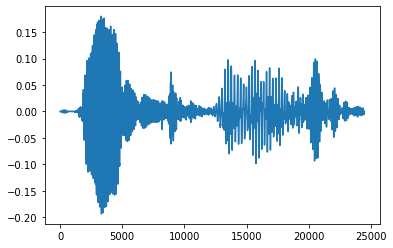

In [96]:
Audio(audio_tensor.numpy(), rate=audio.rate.numpy())
import matplotlib.pyplot as plt
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
plt.figure()
plt.plot(tensor.numpy())

In [44]:
spectrogram.shape

(1, 343, 129, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


TypeError: ignored

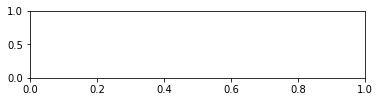

In [43]:
ax = fig.add_subplot(1, num_spectrograms_to_show, 1)
spectrogram, label = next(dataset_iter)
spectrogram = spectrogram.numpy()
label = label.numpy()
plt.imshow(np.flipud(np.squeeze(spectrogram, -1).T), aspect=0.2)
ax.set_title("Example of \"%s\"" % WORDS[label])
ax.set_xlabel("Time frame #")

In [ ]:
#input_wav_paths
ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
len(list(ds))

In [ ]:
 # Read audio waveform from the .wav files.
ds = ds.map(read_wav)
len(list(ds))

In [ ]:
ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
len(list(ds))

In [ ]:
# Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
ds = ds.filter(filter_by_waveform_length)
len(list(ds))

In [ ]:
 # Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
# spectrograms using the preprocessing layer.
ds = ds.map(crop_and_convert_to_spectrogram)
len(list(ds))

In [ ]:
# Discard examples that contain infinite or NaN elements.
ds = ds.filter(spectrogram_elements_finite)
len(list(ds))

In [15]:
input_wav_paths_and_labels = []
for i, word in enumerate(['du_coup', '_background_noise_snippets_']):
  wav_paths = glob.glob(os.path.join(data_dir, word, "*.wav"))
  print("Found %d examples for class %s" % (len(wav_paths), word))
  labels = [i] * len(wav_paths)
  input_wav_paths_and_labels.extend(zip(wav_paths, labels))

random.shuffle(input_wav_paths_and_labels)
  
input_wav_paths, labels = ([t[0] for t in input_wav_paths_and_labels],
                           [t[1] for t in input_wav_paths_and_labels])

Found 1116 examples for class du_coup
Found 817 examples for class _background_noise_snippets_


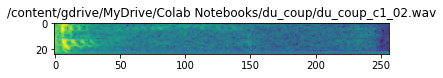

In [25]:
def get_spectrogram(f):
  audio = tfio.audio.AudioIOTensor(f)
  audio_tensor = tf.squeeze(audio.to_tensor(), axis=[-1])
  tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
  spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
  return spectrogram

f = input_wav_paths[0]
f = '/content/gdrive/MyDrive/Colab Notebooks/du_coup/du_coup_c1_02.wav'
s = get_spectrogram(f)
plt.figure()
plt.title(f)
plt.imshow(tf.math.log(s).numpy())

In [78]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  res = tf.squeeze(audio, axis=-1)
  return res


def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]


def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def show_waveform(waveform, label):
  plt.xlim([0, BITRATE])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.plot(waveform.numpy())
  label = label.numpy().decode('utf-8')
  plt.title(file)
  plt.show()

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = BITRATE
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [BITRATE] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

BITRATE = 16000

def show_wav_and_spectrogram(wav, s, f):
  fig, axes = plt.subplots(2, figsize=(8, 8))
  timescale = np.arange(wav.shape[0])
  axes[0].plot(timescale, wav.numpy())
  axes[0].set_title(f)
  axes[0].set_xlim([0, BITRATE])

  plot_spectrogram(s.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.show()

def show_spectrogram(s, f, ax):
  plot_spectrogram(s.numpy(), ax)
  ax.set_title(f)

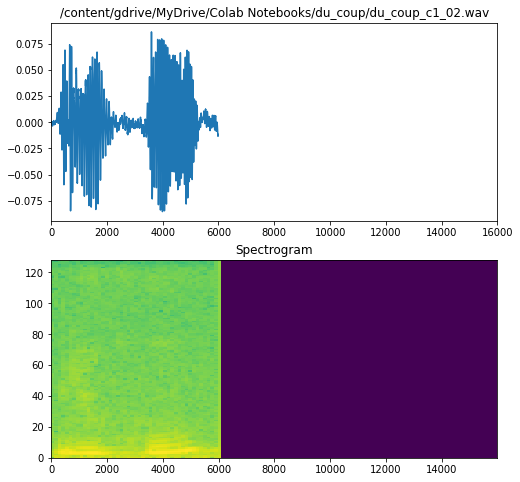

In [67]:
f = '/content/gdrive/MyDrive/Colab Notebooks/du_coup/du_coup_c1_02.wav'
wav, l = get_waveform_and_label(f)
s = get_spectrogram(wav)
show_wav_and_spectrogram(wav, s, f)

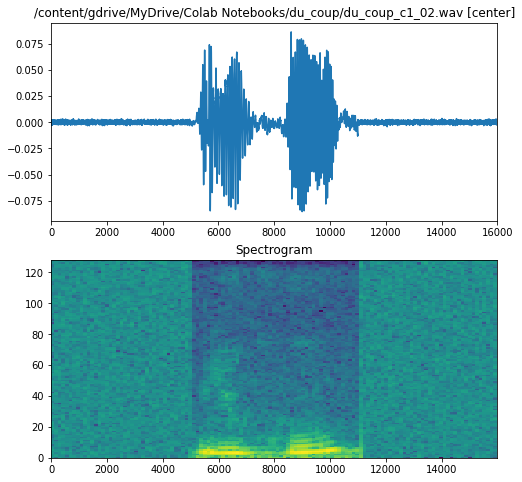

In [39]:
wav_center = get_center_sample(wav)
s_center = get_spectrogram(wav_center)
show_wav_and_spectrogram(wav_center, s_center, f + ' [center]')

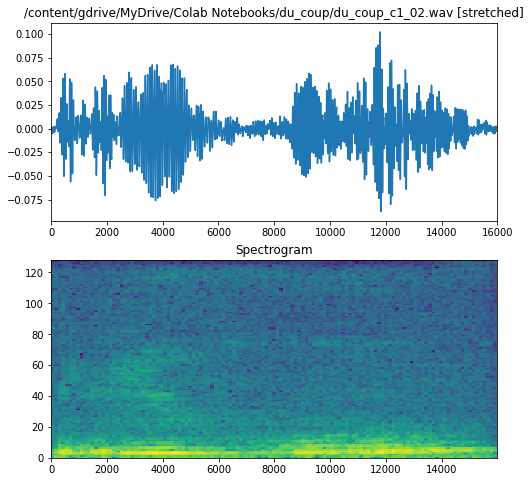

In [40]:
wav_stretched = get_stretched_sample(wav)
s_stretched = get_spectrogram(wav_stretched)
show_wav_and_spectrogram(wav_stretched, s_stretched, f + ' [stretched]')

In [59]:
def get_spectrograms(path):
  spectrograms = []
  for f in wav_paths:
    audio_binary = tf.io.read_file(f)
    wav = decode_audio(audio_binary)
    s = get_spectrogram(wav)
    spectrograms.append(s)
  return spectrograms

input_spectrograms_and_labels = []

du_coup_dir = '/content/gdrive/MyDrive/Colab Notebooks/du_coup/'
du_coup_paths = glob.glob(os.path.join(du_coup_dir, "*.wav"))
spectrograms = get_spectrograms(du_coup_paths)
print("'du coup' : %d spectrograms " % (len(spectrograms)))
labels = [0] * len(spectrograms)
input_spectrograms_and_labels.extend(zip(spectrograms, labels))

noise_paths = glob.glob(os.path.join(data_dir, '_background_noise_snippets_', "*.wav"))
spectrograms = get_spectrograms(noise_paths)
print("'noise' : %d spectrograms " % (len(spectrograms)))
labels = [1] * len(spectrograms)
input_spectrograms_and_labels.extend(zip(spectrograms, labels))

random.shuffle(input_spectrograms_and_labels)
  
input_spectrograms, labels = ([t[0] for t in input_spectrograms_and_labels],
                              [t[1] for t in input_spectrograms_and_labels])

#ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)


'du coup' : 817 spectrograms 
'noise' : 817 spectrograms 
[<tf.Tensor: shape=(124, 129, 1), dtype=float32, numpy=
array([[[9.7546253e+00],
        [5.6800284e+00],
        [6.1046660e-01],
        ...,
        [2.4130244e-03],
        [7.1799016e-04],
        [2.2840500e-04]],

       [[9.4651312e-02],
        [2.6778734e+00],
        [1.4205866e+00],
        ...,
        [1.4478932e-03],
        [6.9617084e-04],
        [3.3430383e-04]],

       [[3.9219141e+00],
        [3.5354044e+00],
        [1.5077773e+00],
        ...,
        [2.2695973e-03],
        [6.6636992e-04],
        [7.4267387e-05]],

       ...,

       [[3.7194512e+00],
        [2.6838121e+00],
        [9.9666119e-01],
        ...,
        [3.3795163e-03],
        [5.4111384e-04],
        [1.6140938e-04]],

       [[9.8701400e-01],
        [1.1987252e+00],
        [8.6599159e-01],
        ...,
        [3.3133971e-03],
        [7.7385502e-04],
        [6.7478418e-04]],

       [[2.9706244e+00],
        [2.5730453e+00]

In [60]:
input_spectrograms, labels = ([t[0] for t in input_spectrograms_and_labels],
                              [t[1] for t in input_spectrograms_and_labels])

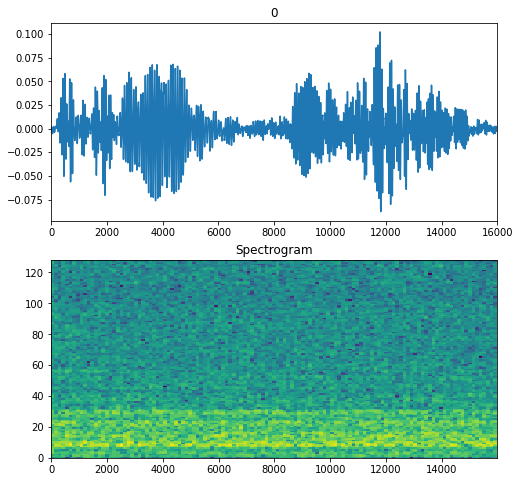

In [66]:
show_wav_and_spectrogram(wav_stretched, input_spectrograms[1], labels[1])

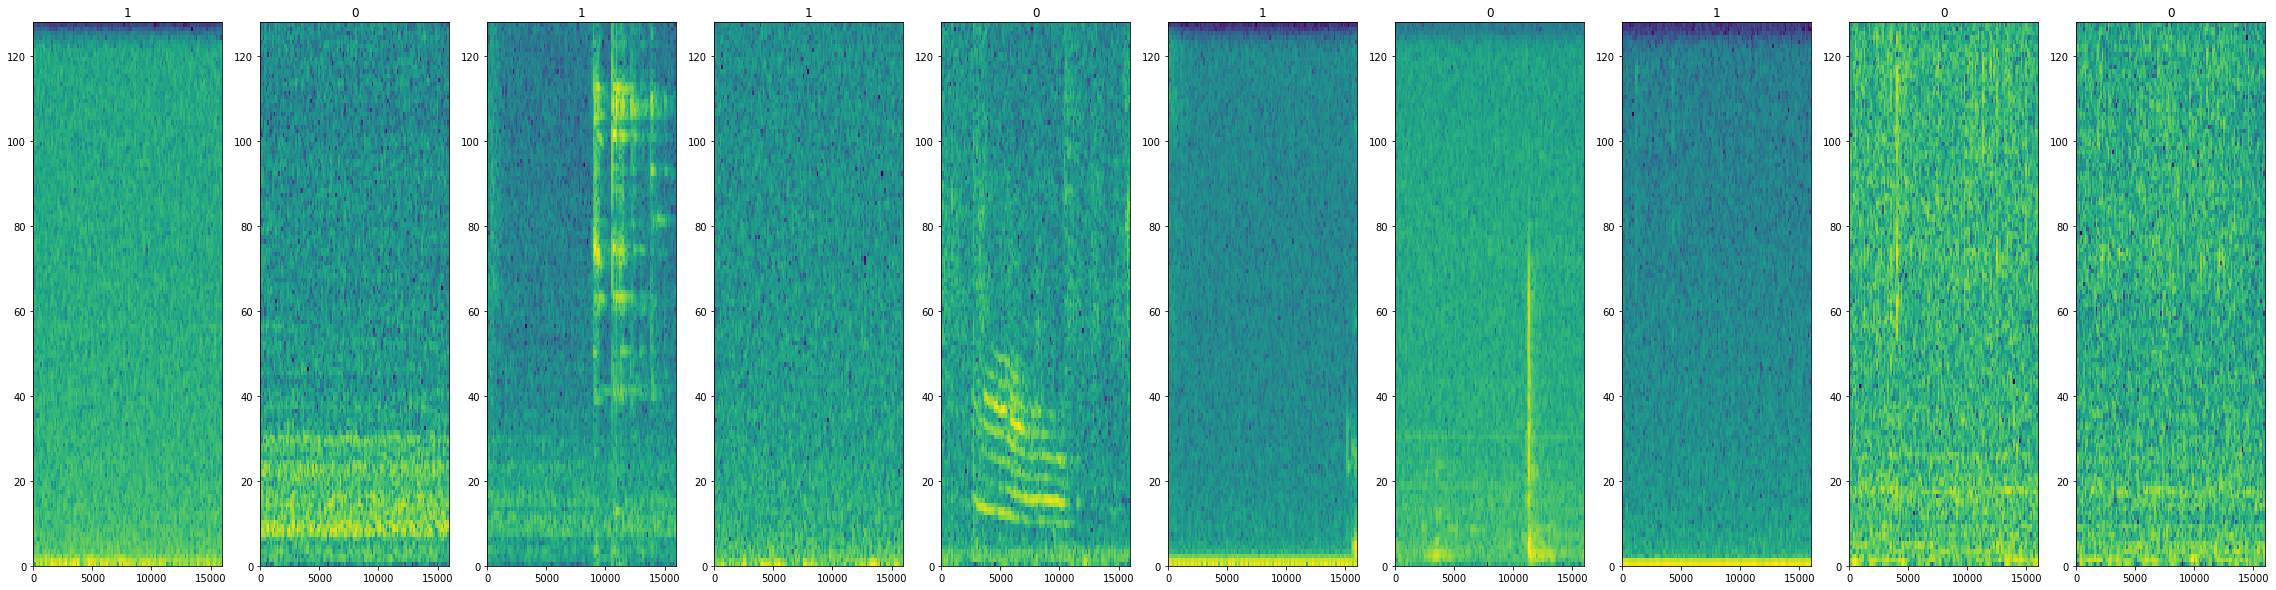

In [79]:
fig = plt.figure(figsize=(40, 10))
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  s = input_spectrograms[i]
  show_spectrogram(s, labels[i], ax)
plt.show()

In [ ]:
# The amount of data we have is relatively small. It fits into typical host RAM
# or GPU memory. For better training performance, we preload the data and
# put it into numpy arrays:
# - xs: The audio features (normalized spectrograms).
# - ys: The labels (class indices).
print(
    "Loading dataset and converting data to numpy arrays. "
    "This may take a few minutes...")
xs_and_ys = list(dataset)
xs = np.stack([item[0] for item in xs_and_ys])
ys = np.stack([item[1] for item in xs_and_ys])
print("Done.")

In [ ]:
dataset

In [ ]:
xs_and_ys[2][0]

In [ ]:
tfjs_model_json_path = '/tmp/tfjs-sc-model/model.json'

# Load the Speech Commands model. Weights are loaded along with the topology,
# since we train the model from scratch. Instead, we will perform transfer
# learning based on the model.
orig_model = tfjs.converters.load_keras_model(tfjs_model_json_path, load_weights=True)

# Remove the top Dense layer and add a new Dense layer of which the output
# size fits the number of sound classes we care about.
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in orig_model.layers[:-1]:
  model.add(layer)
model.add(tf.keras.layers.Dense(units=len(WORDS), activation="softmax"))

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

In [ ]:
# Train the model.
model.fit(xs, ys, batch_size=256, validation_split=0.3, shuffle=True, epochs=50)

In [ ]:
WORDS[1:]

In [ ]:
# Convert the model to TensorFlow.js Layers model format.

tfjs_model_dir = "/tmp/tfjs-model"
tfjs.converters.save_keras_model(model, tfjs_model_dir)

# Create the metadata.json file.
metadata = {"words": ["_background_noise_", 'du_coup'], "frameSize": model.input_shape[-2]}
with open(os.path.join(tfjs_model_dir, "metadata.json"), "w") as f:
  json.dump(metadata, f)

In [ ]:
tfjs_model_dir

In [ ]:
!ls -lh /tmp/tfjs-model

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tfjs_model_dir + '/group1-shard1of2.bin')
  files.download(tfjs_model_dir + '/group1-shard2of2.bin')
  files.download(tfjs_model_dir + '/metadata.json')
  files.download(tfjs_model_dir + '/model.json')